# 라이브러리

In [262]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
import os
import copy

from PIL import Image, ImageDraw

# GPU

In [263]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [264]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


# dataset

In [265]:
DATA_PATH =  os.getenv('HOME') + '/aiffel/GoingDeeper/GD4/data'

In [266]:
(ds_train1, ds_test1), ds_info1 = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [267]:
ds_info1

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/GoingDeeper/GD4/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
      

In [268]:
ds_info1.splits['validation']

<SplitInfo num_examples=423, num_shards=4>

오호 validation이 있다!!

In [269]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [270]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(6347, shape=(), dtype=int64)
tf.Tensor(423, shape=(), dtype=int64)
tf.Tensor(711, shape=(), dtype=int64)


In [271]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/GoingDeeper/GD4/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
      

In [272]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/file_name': Text(shape=(), dtype=tf.string),
    'objects': Sequence({
        'alpha': tf.float32,
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'dimensions': Tensor(shape=(3,), dtype=tf.float32),
        'location': Tensor(shape=(3,), dtype=tf.float32),
        'occluded': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
        'rotation_y': tf.float32,
        'truncated': tf.float32,
        'type': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
})

In [273]:
NUM_CLASSES = ds_info.features['objects']['type'].num_classes
print(NUM_CLASSES)

8


In [274]:
CLASS_NAMES = ds_info.features['objects']['type'].names
print(CLASS_NAMES)

['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc']


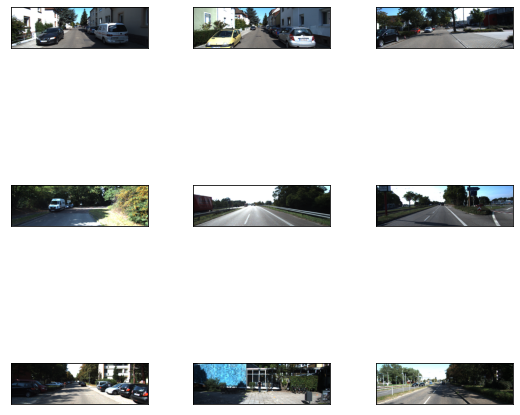

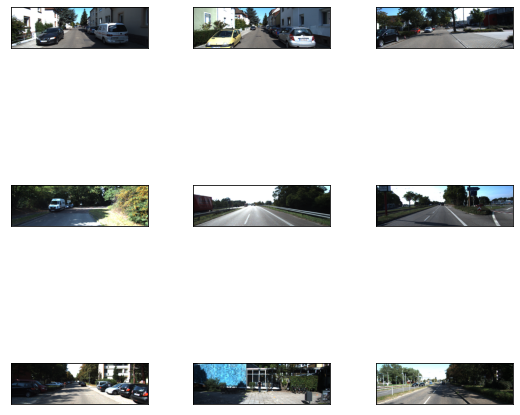

In [275]:
tfds.show_examples(ds_train, ds_info)

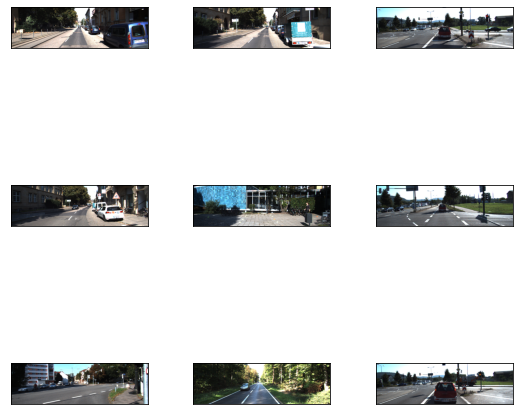

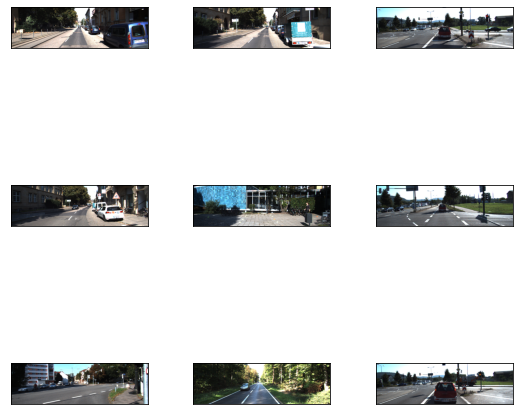

In [276]:
tfds.show_examples(ds_val, ds_info)

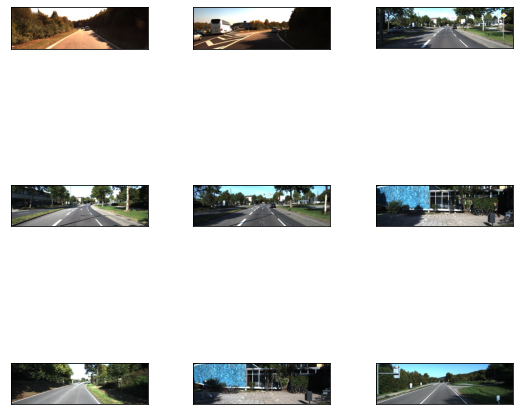

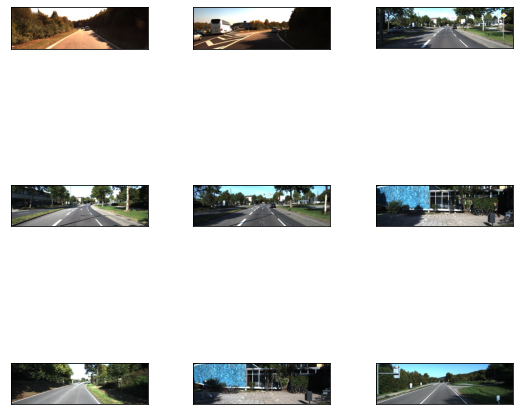

In [277]:
tfds.show_examples(ds_test, ds_info)

In [278]:
list(ds_info.features)

['image', 'image/file_name', 'objects']

In [279]:
list(ds_train.take(1).as_numpy_iterator())

[{'image': array([[[ 16,  19,  14],
          [ 16,  18,  14],
          [ 20,  18,  14],
          ...,
          [  4,   6,   5],
          [  4,   5,   4],
          [  3,   4,   4]],
  
         [[ 10,  22,  19],
          [  4,  17,  21],
          [  8,  20,  20],
          ...,
          [  3,   6,   5],
          [  3,   4,   4],
          [  2,   3,   4]],
  
         [[154,  30,  18],
          [145,  46,  18],
          [105,  57,  17],
          ...,
          [  3,   4,   3],
          [  2,   3,   3],
          [  2,   3,   3]],
  
         ...,
  
         [[123, 176, 125],
          [115, 181, 115],
          [131, 145, 108],
          ...,
          [103, 102, 100],
          [117, 106,  97],
          [125, 118, 100]],
  
         [[115, 101,  67],
          [111,  88,  55],
          [135,  84,  44],
          ...,
          [101, 115, 124],
          [114, 116, 121],
          [126, 123, 121]],
  
         [[ 99,  94,  47],
          [106,  89,  46],
          [104,

In [280]:
sample = ds_train.take(1)


for example in sample :
    print('------Example------')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    filename1 = example['image/file_name'].numpy()
    objects = example['objects']
    print('------image------')
    print(image)
    print('------filename-----')
    print(filename)
    print(filename1)
    print('------objects------')
    print(objects)

------Example------
['image', 'image/file_name', 'objects']
------image------
tf.Tensor(
[[[ 16  15  13]
  [ 16  15  13]
  [ 15  16  13]
  ...
  [ 70  85 183]
  [ 71  70 106]
  [ 57  56 116]]

 [[ 17  17  12]
  [ 17  15  12]
  [ 15  15  12]
  ...
  [140 145 179]
  [125 128 154]
  [100 117 176]]

 [[  8  14  12]
  [  8  14  12]
  [ 11  14  12]
  ...
  [137 214 255]
  [128 200 255]
  [121 185 255]]

 ...

 [[ 17  17  18]
  [ 18  17  17]
  [ 16  18  17]
  ...
  [ 64  64  64]
  [ 61  64  63]
  [ 59  63  66]]

 [[ 17  22  25]
  [ 18  22  25]
  [ 16  23  26]
  ...
  [ 64  64  64]
  [ 61  65  63]
  [ 58  66  65]]

 [[ 24  27  25]
  [ 25  27  26]
  [ 25  26  26]
  ...
  [ 59  63  65]
  [ 61  64  63]
  [ 63  65  64]]], shape=(375, 1242, 3), dtype=uint8)
------filename-----
006512.png
b'006512.png'
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.58, -1.7 ,  2.07,  1.81], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.458533

utf -8 :
https://scribblinganything.tistory.com/347 

bbox, dimension, location : 6개 -> box 6개

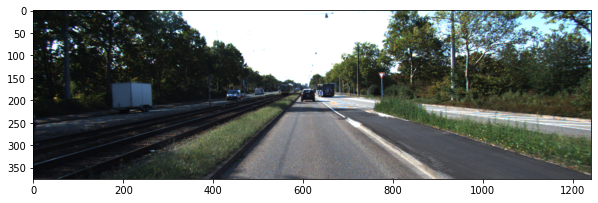

In [281]:
# tensor로 이미지 나타내기
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [282]:
# tensor를 PIL 써서 이미지 나타내기
# Assuming `image` is a TensorFlow tensor
# Convert the tensor to a NumPy array
image_np = image.numpy()

# Convert the NumPy array to a PIL Image
pil_image = Image.fromarray(image_np)

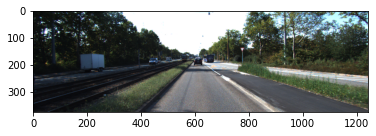

In [283]:
# 얘는 LMS 노드
img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [284]:
# 이미지 위에 바운딩 박스 그리기
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = input_image.size
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height


    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis =1)
    for _rect in rects :
        draw.rectangle(_rect, outline=(255,0,0), width =10)

    return input_image

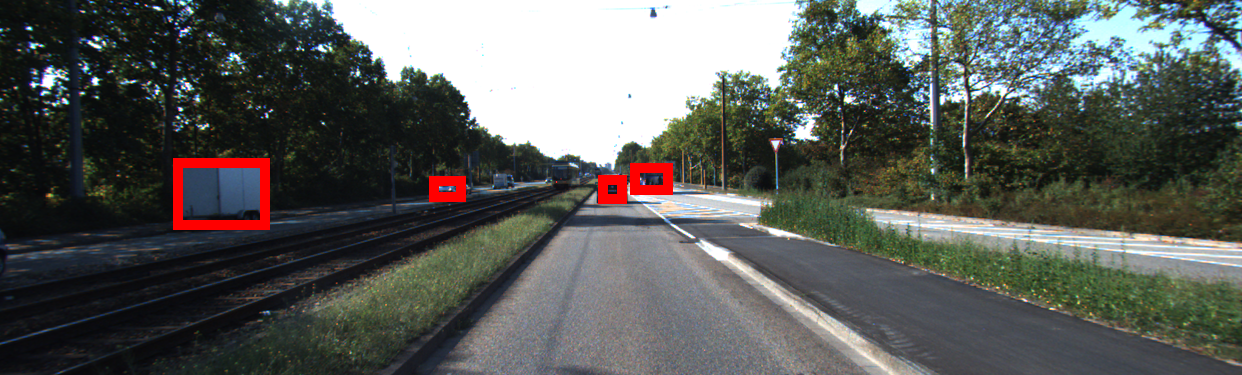

In [285]:
visualize_bbox(img, objects['bbox'].numpy())

# preprocessing

In [286]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


In [287]:
# axis = -1 비교
print(objects['bbox'])
print(swap_xy(objects['bbox']))

tf.Tensor(
[[0.45853335 0.48190016 0.53154665 0.50479066]
 [0.48194668 0.5078583  0.5639733  0.5416506 ]
 [0.38866666 0.13966183 0.5778133  0.21673107]
 [0.46234667 0.3459662  0.52888    0.37517715]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.48190016 0.45853335 0.50479066 0.53154665]
 [0.5078583  0.48194668 0.5416506  0.5639733 ]
 [0.13966183 0.38866666 0.21673107 0.5778133 ]
 [0.3459662  0.46234667 0.37517715 0.52888   ]], shape=(4, 4), dtype=float32)


In [288]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

* 이미지 크기 조정 및 패딩 추가

    * 이미지의 비율은 그대로 유지
    * 이미지의 최대/최소 크기 제한
    * 모델에 입력되는 이미지 크기 = stride 의 배수
    * 이미지에 패딩을 더해 모델에 입력되는 이미지에는 검정 테두리가 있게 됨

In [289]:
def resize_and_pad_image(image, training=True):
    # 기본 크기 설정
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    # 입력 이미지의 크기
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    # 훈련 중에는 랜덤하게 최소 크기 선택
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    
    # 이미지를 리사이징할 비율 계산
    ratio = min_side / tf.reduce_min(image_shape)
    
    # 만약 이미지의 크기가 최대 크기를 초과하면 비율을 조정
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    
    # 이미지를 계산된 비율로 리사이징
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    
    # 패딩을 위한 새로운 이미지 크기 계산
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    
    # 이미지를 패딩
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    
    return image, image_shape, ratio

In [290]:
# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    # 바운딩 박스를 (x, y, width, height) 형식으로 변환
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

In [291]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


# anchor box

In [292]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [293]:
# 입력 데이터 anchor box에 맞게 변형
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [294]:
# IoU 계산 함수
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

### class LabelEncoder

* 라벨을 Anchor Box 에 맞추는 클래스
* IoU 를 기준으로 물체에 해당하는 Anchor Box 와 배경이 되는 Anchor Box 지정 -> Anchor Box 와 실제 Bounding Box 의 차이 계산해서 상하좌우/가로세로 크기 차이를 로그로 기록
    * 물체: IoU 0.5 보다 높은 경우
    * 배경: IoU 0.4 보다 낮은 경우
* variance
    * 상하좌우 차이 0.1, 가로세로 크기 차이 0.2 사용
    * 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견 있음

In [295]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# model

* RetinaNet
    * FPN(Feature pyramid Network)

In [296]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


* Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요 => head
    * class를 예측하는 head
    * box를 예측하는 head

In [297]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

* ResNet50
    * RetinaNet 의 backbone
    * FPN 에 이용할 수 있도록 중간 레이어를 output 으로 연결

In [298]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


#### RetinaNet class

* Backbone + FPN + classification용 head + box용 head

In [299]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


#### RetinaNetBoxLoss class
* Classification Loss를 계산하는데만 Focal Loss 사용
    * Box Regression
        * Smooth L1 Loss 사용
        * delta를 기준으로 계산이 달라짐
    * Classification Loss
        * Focal Loss 사용
        * alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라짐
       

In [300]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

# model 학습

In [301]:
BATCH_SIZE = 2
EPOCHS = 10

In [302]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(NUM_CLASSES)
model = RetinaNet(NUM_CLASSES, resnet50_backbone)


* Learning Rate 설정
    * 논문에서는 8개의 GPU를 사용했기 때문에 적절히 바꿔야 함
   

In [303]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

In [304]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
ds_train = ds_train.map(preprocess_data, num_parallel_calls=autotune)
ds_train = ds_train.shuffle(8 * BATCH_SIZE)
ds_train = ds_train.padded_batch(
    batch_size=BATCH_SIZE, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_train = ds_train.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
ds_train = ds_train.prefetch(autotune)

ds_val = ds_val.map(preprocess_data, num_parallel_calls=autotune)
ds_val = ds_val.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_val = ds_val.map(label_encoder.encode_batch, num_parallel_calls=autotune)
ds_val = ds_val.prefetch(autotune)

In [305]:
ds_test = ds_test.map(preprocess_data, num_parallel_calls=autotune)
ds_test = ds_test.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
ds_test = ds_test.map(label_encoder.encode_batch, num_parallel_calls=autotune)
ds_test = ds_test.prefetch(autotune)

In [306]:
MODEL_PATH = DATA_PATH + f'/weights_epoch_{EPOCHS}'
MODEL_PATH

'/aiffel/aiffel/GoingDeeper/GD4/data/weights_epoch_10'

In [307]:
callbacks = keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [308]:
history = model.fit(
    ds_train,
    validation_data = ds_val,
    epochs = EPOCHS,
    callbacks = [callbacks]
)

Epoch 1/10
3173/3173 [==============================] - 1601s 502ms/step - loss: 2.3527 - accuracy: 0.2551 - val_loss: 1.5854 - val_accuracy: 0.2072

Epoch 00001: val_accuracy improved from -inf to 0.20720, saving model to /aiffel/aiffel/GoingDeeper/GD4/data/weights_epoch_10


INFO:tensorflow:Assets written to: /aiffel/aiffel/GoingDeeper/GD4/data/weights_epoch_10/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/GoingDeeper/GD4/data/weights_epoch_10/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
3173/3173 [==============================] - 1602s 504ms/step - loss: 1.0340 - accuracy: 0.2293 - val_loss: 1.2753 - val_accuracy: 0.2677

Epoch 00002: val_accuracy improved from 0.20720 to 0.26767, saving model to /aiffel/aiffel/GoingDeeper/GD4/data/weights_epoch_10


INFO:tensorflow:Assets written to: /aiffel/aiffel/GoingDeeper/GD4/data/weights_epoch_10/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/GoingDeeper/GD4/data/weights_epoch_10/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/10
3173/3173 [==============================] - 1599s 504ms/step - loss: 0.7406 - accuracy: 0.2168 - val_loss: 1.0668 - val_accuracy: 0.2054

Epoch 00003: val_accuracy did not improve from 0.26767
Epoch 4/10
3173/3173 [==============================] - 1602s 504ms/step - loss: 0.5981 - accuracy: 0.2080 - val_loss: 1.2152 - val_accuracy: 0.1951

Epoch 00004: val_accuracy did not improve from 0.26767
Epoch 5/10
3173/3173 [==============================] - 1602s 505ms/step - loss: 0.4992 - accuracy: 0.2122 - val_loss: 0.9974 - val_accuracy: 0.1963

Epoch 00005: val_accuracy did not improve from 0.26767
Epoch 6/10
3173/3173 [==============================] - 1602s 505ms/step - loss: 0.4190 - accuracy: 0.1987 - val_loss: 1.0047 - val_accuracy: 0.2175

Epoch 00006: val_accuracy did not improve from 0.26767
Epoch 7/10
3173/3173 [==============================] - 1602s 504ms/step - loss: 0.3644 - accuracy: 0.1987 - val_loss: 0.9411 - val_accuracy: 0.2135

Epoch 00007: val_accuracy did 

In [309]:
result = model.evaluate(ds_test)

711/711 [==============================] - 66s 91ms/step - loss: 0.8775 - accuracy: 0.1764


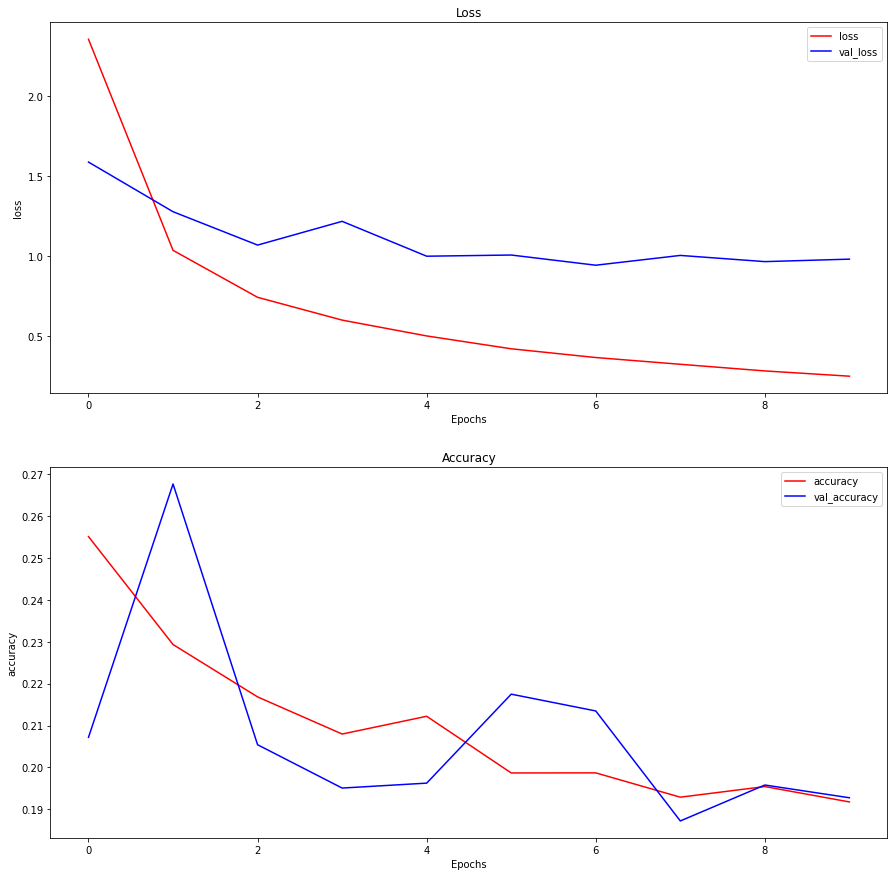

In [310]:
plt.subplots(figsize = (15,15))

plt.subplot(211)
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

plt.subplot(212)
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])

In [311]:
model.save_weights(MODEL_PATH)

#### class DecodePredictions
* 모델의 추론 결과를 처리할 함수를 레이어 형식으로 생성
    * 현재 구현으로는 100개의 후보만 골라 처리할 예정
    * 논문: 0.05보다 높은 box 1000개를 골라 0.5 NMS 진행
    
* NMS(Non-Max Suppression)

In [312]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [313]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)


In [314]:
CLASS_NAMES

['Car',
 'Van',
 'Truck',
 'Pedestrian',
 'Person_sitting',
 'Cyclist',
 'Tram',
 'Misc']

In [315]:
CAR_LIST = ['Car', 'Van', 'Truck', 'Tram']
PEOPLE_LIST = ['Pedestrian', 'Person_sitting', 'Cyclist']
ELSE_LIST = ['Misc']

In [316]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        
        if _cls in CAR_LIST :
            color = [1,0,0]  # car => red 
        elif _cls in PEOPLE_LIST :
            color = [0,1,0]  # people => green
        elif _cls in ELSE_LIST :
            color = [0,0,1]  # else => blue
        
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

* 추론시 입력 데이터를 전처리 하기 위한 함수
* 학습을 위한 전처리와 다름!!

In [317]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


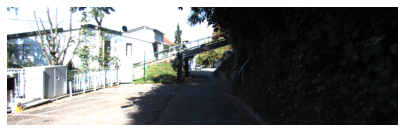

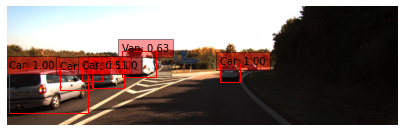

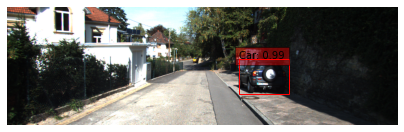

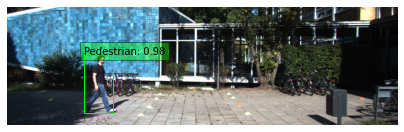

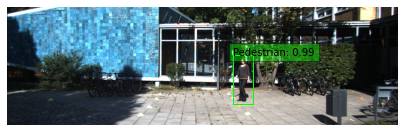

In [318]:
int2str = ds_info.features["objects"]["type"].int2str

for sample in ds_test1.take(5):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# autonomous

In [324]:
def self_drive_assist(img_path, size_limit=300):
    image = Image.open(img_path)
    input_image, ratio = prepare_image(image)
    
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    
    
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    # 정지 조건 : 사람 한 명이상
    #if any(people in class_names for people in PEOPLE_LIST):
    #    print(people)
    #    return "Stop"
    for _,people in enumerate(class_names):
        if people in PEOPLE_LIST :
            print(people)
            return "Stop"
    
    # 정지 조건 : 차량 크기 300px 이상
    for box in detections.nmsed_boxes[0][:num_detections] / ratio :
        x1, y1, x2, y2 = box
        w = x2-x1
        h = y2-y1
        print(f'width : {w} , height : {h}')
        if w>=size_limit or h>= size_limit :
            return "Stop"
    
    #나머지 Go
    else :
        return 'Go'

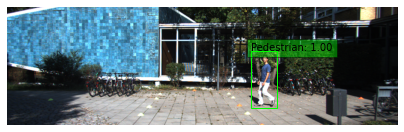

Pedestrian
pred : Stop , answer : Stop


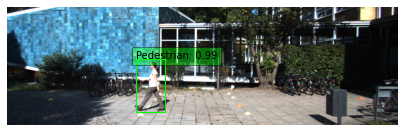

Pedestrian
pred : Stop , answer : Stop


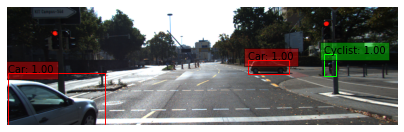

Cyclist
pred : Stop , answer : Stop


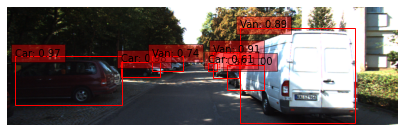

width : 115.66741943359375 , height : 79.77928924560547
width : 123.4312744140625 , height : 46.38233947753906
width : 339.6026611328125 , height : 155.49240112304688
pred : Stop , answer : Stop


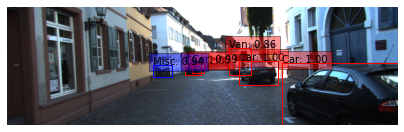

width : 52.26544189453125 , height : 36.785491943359375
width : 125.06536865234375 , height : 76.92313385009766
width : 367.74609375 , height : 196.6240692138672
pred : Stop , answer : Stop


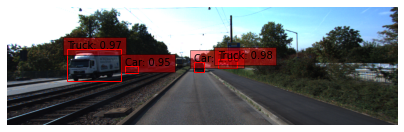

width : 30.880126953125 , height : 30.577438354492188
width : 60.578369140625 , height : 30.2447509765625
width : 172.67324829101562 , height : 102.68464660644531
width : 42.527313232421875 , height : 23.638519287109375
pred : Go , answer : Go


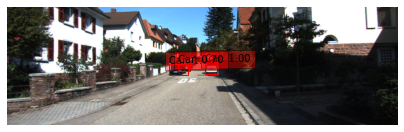

width : 59.39044189453125 , height : 36.26759338378906
width : 36.86993408203125 , height : 38.76521301269531
width : 36.53558349609375 , height : 26.770004272460938
pred : Go , answer : Go


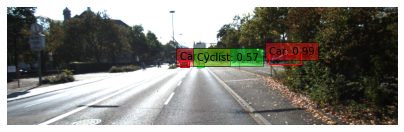

Cyclist
pred : Stop , answer : Go


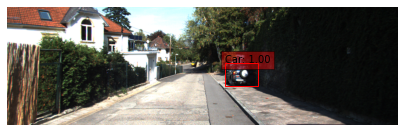

width : 106.376953125 , height : 72.63246154785156
pred : Go , answer : Go


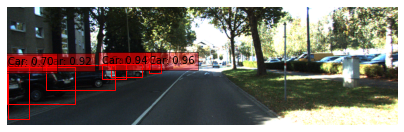

width : 98.27236938476562 , height : 43.167633056640625
width : 215.6328887939453 , height : 117.68093872070312
width : 39.9088134765625 , height : 30.273590087890625
width : 78.119140625 , height : 48.262847900390625
width : 219.6572265625 , height : 78.81981658935547
width : 69.03592681884766 , height : 172.80294799804688
pred : Go , answer : Go
총 90점입니다.


In [325]:
def test_system(func):
    work_dir = DATA_PATH
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            print(f'pred : {pred} , answer : {answer}')
            score += 10
            
        else :
            print(f'pred : {pred} , answer : {answer}')
            
    print(f"총 {score}점입니다.")

test_system(self_drive_assist)

# 회고 

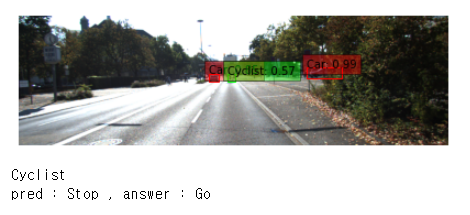

사람이 멀리 있을 때도 정지조건에 포함이 되는데 정확도 높이려면 사람 크기도 조건에 포함 되어 있어야 할 것 같다.

---

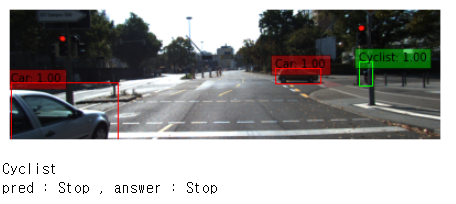

pedestrain 이지만 cyclist 로 잘못 확인 되는 경우도 존재

---

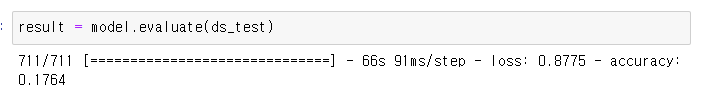

test accuracy 는 망가졌는데 생각보다 물체인식은 잘함

---

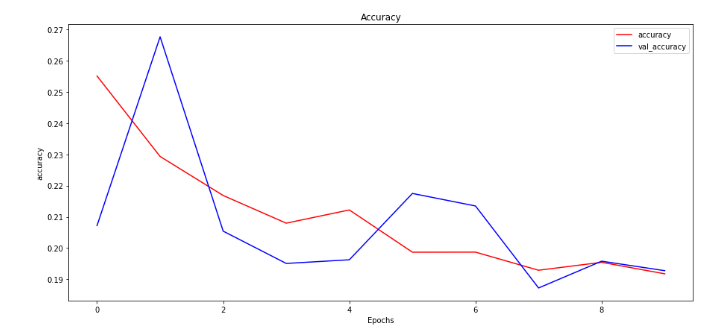

학습할수록 loss가 떨어지는데 accuracy도 떨어지면 어떻게 해야하나?

학습기준을 loss에 맞춰야하는지 accuracy에 맞춰야 하는지 의문

---

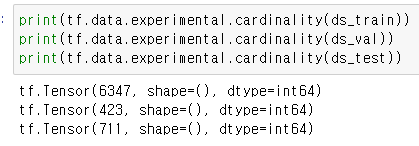

data 불균형 없애고 학습시키고 싶었는데 train_test_split 안돼서 못함 후,,,,,



##### 오늘의 취침시간 7시05분 